## Classify Tweets. Compare classifiers and select best model at run time. 

In [1]:
# Import File and Packages
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import re
import warnings
warnings.filterwarnings("ignore")

# Read csv file into data frame
tweet=pd.read_csv("../input/Tweets.csv")

### Load and preprocess data using NLTK:
##### Tokenize, Clean, Stem, Lemmatize, Remove stopwords

In [2]:
# Preprocess the data {'negative': 0 , 'positive': 1 , 'neutral': 2}

df=tweet.iloc[:,(10,1)]
df.columns = ['data', 'target']
df['target']=df['target'].str.strip().str.lower()
df['target']=df['target'].map({'negative': 0 , 'positive': 1 , 'neutral': 2})

# Copy df to a temporary dataframe for pre-processing
# Below assignment is causing problems
dft=df

In [3]:
%%time
# Remove @tweets, numbers, hyperlinks that do not start with letters
dft['data']=dft['data'].str.replace("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|([0-9])"," ")

# tokenize into words
import nltk
dft['data']=dft['data'].apply(nltk.word_tokenize)

CPU times: user 3.05 s, sys: 100 ms, total: 3.15 s
Wall time: 3.16 s


In [4]:
%%time
# stem the tokens
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
dft['data']=dft['data'].apply(lambda x: [stemmer.stem(y) for y in x])

CPU times: user 3.66 s, sys: 20 ms, total: 3.68 s
Wall time: 3.68 s


In [5]:
%%time
# Lemmatizing
lemmatizer = nltk.WordNetLemmatizer()
dft['data']=dft['data'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

CPU times: user 3.82 s, sys: 64 ms, total: 3.89 s
Wall time: 3.9 s


In [6]:
%%time
# Remove stopwords
stopwords = nltk.corpus.stopwords.words('english')

# stem the stopwords
stemmed_stops = [stemmer.stem(t) for t in stopwords]

# remove stopwords from stemmed/lemmatized tokens
dft['data']=dft['data'].apply(lambda x: [stemmer.stem(y) for y in x if y not in stemmed_stops])

# remove words whose length is <3
dft['data']=dft['data'].apply(lambda x: [e for e in x if len(e) >= 3])

CPU times: user 3.38 s, sys: 76 ms, total: 3.46 s
Wall time: 3.52 s


In [7]:
%%time
# Detokenize cleaned dataframe for vectorizing
dft['data']=dft['data'].str.join(" ")

CPU times: user 156 ms, sys: 4 ms, total: 160 ms
Wall time: 173 ms


### Printing data shape:

In [8]:
#Print attributes of tweet, X and y
print('Shape of original file : ', tweet.shape)
print('All columns of the original file : ', tweet.columns.tolist() , '\n')
print('Columns dft dataframe : ',dft.columns.tolist(), '\n') 
print('Shape data and target : ', dft['data'].shape, dft['target'].shape, '\n')
print('Mood Count target :\n',tweet['airline_sentiment'].value_counts())

Shape of original file :  (14640, 15)
All columns of the original file :  ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'] 

Columns dft dataframe :  ['data', 'target'] 

Shape data and target :  (14640,) (14640,) 

Mood Count target :
 negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


### Printing accuracy using DummyClassifier (baseline) w.r.t Train Test Split:
#### Performance Measure: Accuracy_score and runtime  
##### Testing the dataset using Dummy classifier and train test. Purpose is to find an optimum random state for train test which gives the best accuracy.

In [9]:
%%time
from sklearn.cross_validation import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer

X=dft['data']
y=dft['target']

arr_Accu=[]

#Using train_test_split
#Selecting the best random state and comapring the accuracy using Dummy Classifier
for i in range(1,20):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.67, random_state=i)

    vect = CountVectorizer(stop_words='english',analyzer="word",min_df = 2, max_df = 0.8)
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    feat_dtm = vect.get_feature_names()
    #feat_dtm

    clf = DummyClassifier()
    clf.fit(X_train_dtm, y_train)
    y_pred = clf.predict(X_test_dtm)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    #print(accuracy)
    arr_Accu.append(accuracy)

for j in range(1,20):
    print("Random State : ", j, "   Accuracy : ", arr_Accu[j-1])

Random State :  1    Accuracy :  0.454056291391
Random State :  2    Accuracy :  0.475165562914
Random State :  3    Accuracy :  0.45571192053
Random State :  4    Accuracy :  0.465852649007
Random State :  5    Accuracy :  0.466266556291
Random State :  6    Accuracy :  0.469163907285
Random State :  7    Accuracy :  0.46792218543
Random State :  8    Accuracy :  0.464817880795
Random State :  9    Accuracy :  0.472475165563
Random State :  10    Accuracy :  0.451986754967
Random State :  11    Accuracy :  0.453435430464
Random State :  12    Accuracy :  0.466059602649
Random State :  13    Accuracy :  0.456953642384
Random State :  14    Accuracy :  0.466059602649
Random State :  15    Accuracy :  0.465231788079
Random State :  16    Accuracy :  0.460885761589
Random State :  17    Accuracy :  0.456332781457
Random State :  18    Accuracy :  0.459850993377
Random State :  19    Accuracy :  0.459437086093
CPU times: user 4.54 s, sys: 8 ms, total: 4.55 s
Wall time: 4.62 s


### Printing accuracy using Dummy Classifier w.r.t K-fold:
#### Performance Measure: Accuracy_score and runtime
##### Testing the dataset using dummy classifier and K-fold. Purpose is to find an optimum K value for CV which gives the best accuracy.

In [10]:
%%time
#Using K-fold validation
#Selecting the best fold and comparing the accuracy using Naive Bayes
from sklearn.cross_validation import cross_val_score
arr_Accu=[]

#Selecting the best random state and comparing the accuracy using dummy classifier
for i in range(3,15):

    vect = CountVectorizer(stop_words='english',analyzer="word",min_df = 2, max_df = 0.8)
    X_dtm = vect.fit_transform(X)

    clf = DummyClassifier()
    accuracy = cross_val_score(clf, X_dtm, y, cv=i, scoring='accuracy')
    
    arr_Accu.append(np.mean(accuracy))

#print(arr_Accu)
for j in range(3,15):
    print("K-Fold : ", j, "   Accuracy : ", arr_Accu[j-3])

K-Fold :  3    Accuracy :  0.464754825147
K-Fold :  4    Accuracy :  0.459839197229
K-Fold :  5    Accuracy :  0.458537986687
K-Fold :  6    Accuracy :  0.469668203445
K-Fold :  7    Accuracy :  0.463184585732
K-Fold :  8    Accuracy :  0.462297151229
K-Fold :  9    Accuracy :  0.469668334448
K-Fold :  10    Accuracy :  0.461952977837
K-Fold :  11    Accuracy :  0.463794050987
K-Fold :  12    Accuracy :  0.467142835733
K-Fold :  13    Accuracy :  0.460452132403
K-Fold :  14    Accuracy :  0.464892620348
CPU times: user 3.4 s, sys: 4 ms, total: 3.4 s
Wall time: 3.42 s


### Print top features with frequency:

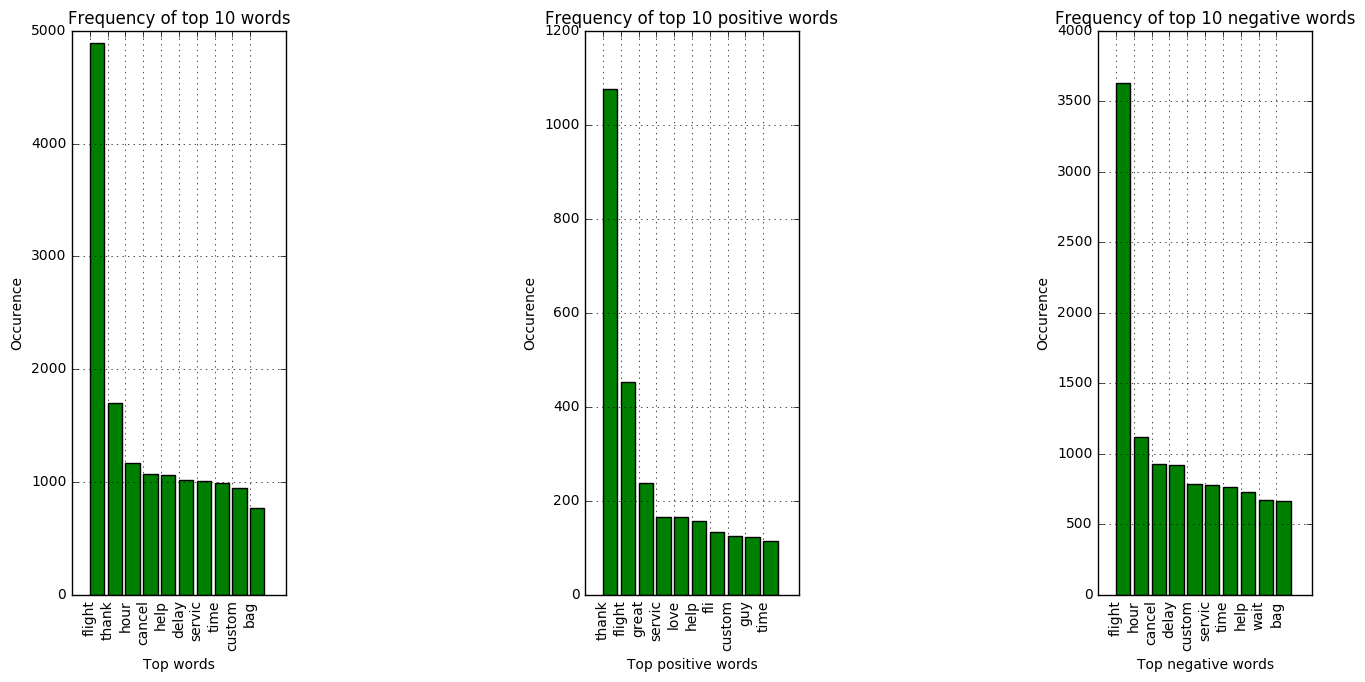

In [11]:
def print_top_words():    
    # Print top words
    vect = CountVectorizer(stop_words='english',analyzer="word",min_df = 2, max_df = 0.8)
    data_dtm = vect.fit_transform(dft['data'])
    feat_dtm = vect.get_feature_names()

    # Count words
    freq_tbl=pd.DataFrame({'Word':feat_dtm,'Occurence':np.asarray(data_dtm.sum(axis=0)).ravel().tolist()})
    freq_tbl['Word']=freq_tbl['Word'].str.strip()

    # Print top words
    topt = freq_tbl.sort(['Occurence'], ascending=[False]).head(10)
    y = topt['Occurence']
    plt.grid()
    X = range(1, 11)
    plt.bar(X,y,color='g')
    plt.xlabel('Top words')
    plt.ylabel('Occurence')
    plt.title('Frequency of top 10 words')
    plt.xticks(X,topt['Word'],rotation=90)
    
def print_top_neg_words():    
    # Print top negative words
    vect = CountVectorizer(stop_words='english',analyzer="word",min_df = 2, max_df = 0.8)
    filt = dft[dft['target'] == 0]
    data_dtm = vect.fit_transform(filt['data'])
    feat_dtm = vect.get_feature_names()

    # Count words
    freq_tbl=pd.DataFrame({'Word':feat_dtm,'Occurence':np.asarray(data_dtm.sum(axis=0)).ravel().tolist()})
    freq_tbl['Word']=freq_tbl['Word'].str.strip()

    # Print top negative words
    topt = freq_tbl.sort(['Occurence'], ascending=[False]).head(10)
    y = topt['Occurence']
    plt.grid()
    X = range(1, 11)
    plt.bar(X,y,color='g')
    plt.xlabel('Top negative words')
    plt.ylabel('Occurence')
    plt.title('Frequency of top 10 negative words')
    plt.xticks(X,topt['Word'],rotation=90)
    
def print_top_pos_words():    
    # Print top positive words
    vect = CountVectorizer(stop_words='english',analyzer="word",min_df = 2, max_df = 0.8)
    filt = dft[dft['target'] == 1]
    data_dtm = vect.fit_transform(filt['data'])
    feat_dtm = vect.get_feature_names()

    # Count words
    freq_tbl=pd.DataFrame({'Word':feat_dtm,'Occurence':np.asarray(data_dtm.sum(axis=0)).ravel().tolist()})
    freq_tbl['Word']=freq_tbl['Word'].str.strip()

    # Print top positive words
    topt = freq_tbl.sort(['Occurence'], ascending=[False]).head(10)
    y = topt['Occurence']
    plt.grid()
    X = range(1, 11)
    plt.bar(X,y,color='g')
    plt.xlabel('Top positive words')
    plt.ylabel('Occurence')
    plt.title('Frequency of top 10 positive words')
    plt.xticks(X,topt['Word'],rotation=90)


plt.figure(1,figsize=(16, 16))
plt.subplot(251)
print_top_words()  
plt.subplot(253)
print_top_pos_words()
plt.subplot(255)
print_top_neg_words()

### Comparing different model accuracy using Train Test:
#### 1. Multinomial Naive Bayes
#### 2. Logistic Regression
#### 3. KNN
#### 4. Decision Tree
#### 5. Random Forest
#### 6. ADA Boost Classifier
#### 7. LinearSVC
#### 8. Gaussian Naive Bayes
### Performance Measure: Accuracy_score and Run time
##### Each model mentioned above will be tested for accuracy and Run time using Train Test and the best performing model will be automatically selected.

In [12]:
%%time
import time
#Train Test split data with random state=11
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.67, random_state=11)

#Vectorize
vect = CountVectorizer(stop_words='english',analyzer="word",min_df = 2, max_df = 0.8)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
feat_dtm = vect.get_feature_names()

#Initialize classifier stats
clf_stats=pd.DataFrame()

CPU times: user 268 ms, sys: 8 ms, total: 276 ms
Wall time: 279 ms


In [13]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

start_time=time.time()
clf.fit(X_train_dtm, y_train)
runtime = time.time()-start_time
y_pred = clf.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred)

print('Accuracy : ',accuracy)

#Store stats for classifier
clf_stats=clf_stats.append({'Classifier': 'Multinomial Naive Bayes', 'Accuracy': accuracy, 'Runtime': runtime, 'Callable': 'clf = MultinomialNB()'}, ignore_index=True)

Accuracy :  0.762210264901


In [14]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

start_time=time.time()
clf.fit(X_train_dtm, y_train)
runtime = time.time()-start_time
y_pred = clf.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy : ',accuracy)

#Store stats for classifier
clf_stats=clf_stats.append({'Classifier': 'Logistic Regression', 'Accuracy': accuracy, 'Runtime': runtime, 'Callable': 'clf = LogisticRegression()'}, ignore_index=True)

Accuracy :  0.770281456954


In [15]:
# K Nearest Neighbour
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=2)

start_time=time.time()
clf.fit(X_train_dtm, y_train)
runtime = time.time()-start_time
y_pred = clf.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred)

print('Accuracy : ',accuracy)

#Store stats for classifier
clf_stats=clf_stats.append({'Classifier': 'KNN', 'Accuracy': accuracy, 'Runtime': runtime, 'Callable': 'clf = KNeighborsClassifier(n_neighbors=2)'}, ignore_index=True)

Accuracy :  0.604718543046


In [16]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='entropy')

start_time=time.time()
clf.fit(X_train_dtm, y_train)
runtime = time.time()-start_time
y_pred = clf.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred)

print('Accuracy : ',accuracy)

#Store stats for classifier
clf_stats=clf_stats.append({'Classifier': 'Decision Trees', 'Accuracy': accuracy, 'Runtime': runtime, 'Callable': 'clf = DecisionTreeClassifier(criterion=''entropy'')'}, ignore_index=True)

Accuracy :  0.685430463576


In [17]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(criterion='entropy')

start_time=time.time()
clf.fit(X_train_dtm, y_train)
runtime = time.time()-start_time
y_pred = clf.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred)

print('Accuracy : ',accuracy)

#Store stats for classifier
clf_stats=clf_stats.append({'Classifier': 'Random Forest', 'Accuracy': accuracy, 'Runtime': runtime, 'Callable': 'clf = RandomForestClassifier(criterion=''entropy'')'}, ignore_index=True)

Accuracy :  0.730546357616


In [18]:
# AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()

start_time=time.time()
clf.fit(X_train_dtm, y_train)
runtime = time.time()-start_time
y_pred = clf.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred)

print('Accuracy : ',accuracy)

#Store stats for classifier
clf_stats=clf_stats.append({'Classifier': 'ADA Boost', 'Accuracy': accuracy, 'Runtime': runtime, 'Callable': 'clf = AdaBoostClassifier()'}, ignore_index=True)

Accuracy :  0.693087748344


In [19]:
# SVM SVC
from sklearn.svm import LinearSVC
clf = LinearSVC()

start_time=time.time()
clf.fit(X_train_dtm, y_train)
runtime = time.time()-start_time
y_pred = clf.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred)

print('Accuracy : ',accuracy)

#Store stats for classifier
clf_stats=clf_stats.append({'Classifier': 'SVM SVC', 'Accuracy': accuracy, 'Runtime': runtime, 'Callable': 'clf = LinearSVC()'}, ignore_index=True)

Accuracy :  0.747930463576


In [20]:
# GaussianNB
# Not good with words
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

start_time=time.time()
clf.fit(X_train_dtm.toarray(), y_train)
runtime = time.time()-start_time
y_pred = clf.predict(X_test_dtm.toarray())
accuracy = metrics.accuracy_score(y_test, y_pred)

print('Accuracy : ',accuracy)

#Store stats for classifier
clf_stats=clf_stats.append({'Classifier': 'Gaussian NB', 'Accuracy': accuracy, 'Runtime': runtime, 'Callable': 'clf = GaussianNB()'}, ignore_index=True)

Accuracy :  0.378518211921


### Plotting Classifier vs Accuracy and Runtime:

                Classifier  Accuracy   Runtime
1      Logistic Regression  0.770281  0.137723
0  Multinomial Naive Bayes  0.762210  0.003662
6                  SVM SVC  0.747930  0.452993
4            Random Forest  0.730546  0.940945
5                ADA Boost  0.693088  0.381215
3           Decision Trees  0.685430  1.045885
2                      KNN  0.604719  0.001214
7              Gaussian NB  0.378518  0.702168


([<matplotlib.axis.XTick at 0x7f5f298a81d0>,
 <a list of 8 Text xticklabel objects>)

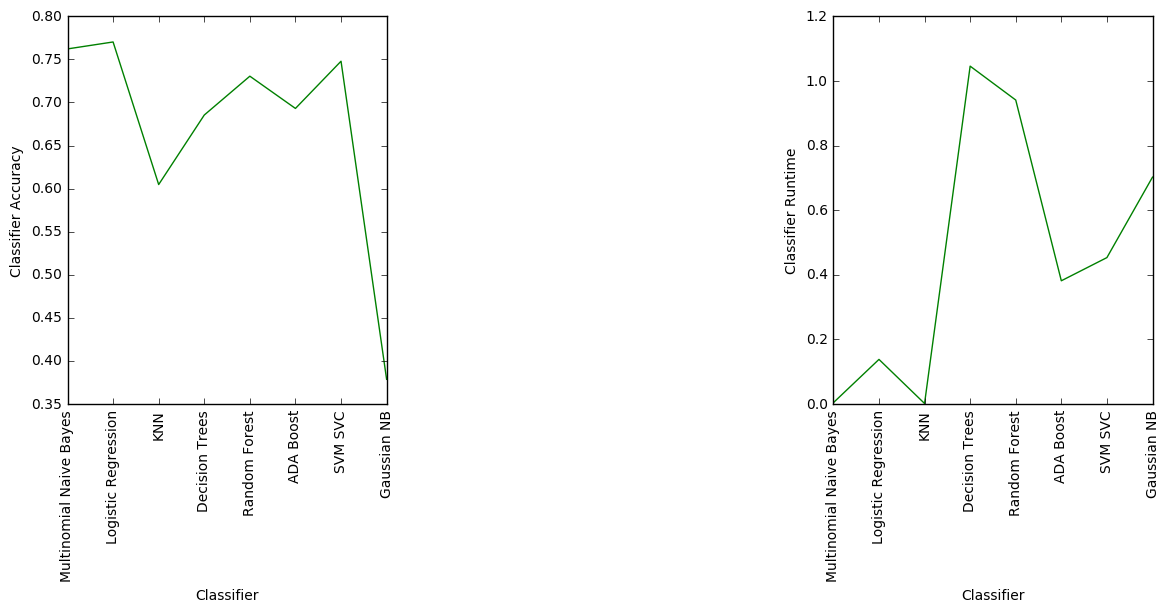

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

print (clf_stats[['Classifier','Accuracy','Runtime']].sort(['Accuracy'], ascending=[False]))
#Plot performance measures of classifiers

x=range(1,(len(clf_stats.Classifier)+1))
plt.figure(1,figsize=(14, 5))

plt.subplot(131)
plt.xlabel('Classifier')
plt.ylabel('Classifier Accuracy')
plt.plot(x, clf_stats['Accuracy'],color='g')
plt.xticks(x,clf_stats.Classifier,rotation=90)

plt.subplot(133)
plt.xlabel('Classifier')
plt.ylabel('Classifier Runtime')
plt.plot(x, clf_stats['Runtime'],color='g')
plt.xticks(x,clf_stats.Classifier,rotation=90)    

### Classifying new tweets: Fit model, Clean Tweet, Predict Mood
#### Clean incoming new tweet:

In [22]:
# Clean input tweet

def fmt_input_tweet(txt):
    
    # Remove @tweets, numbers, hyperlinks that do not start with letters
    txt = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|([0-9])"," ",txt)
    #print(txt)
    
    # tokenize into words
    tokens = [word for word in nltk.word_tokenize(txt)]
    #print(tokens)

    # only keep tokens that start with a letter (using regular expressions)
    clean_tokens = [token for token in tokens if re.search(r'^[a-zA-Z]+', token)]
    #print('clean_tokens:\n',clean_tokens)

    # stem the tokens
    stemmer = SnowballStemmer('english')
    stemmed_tokens = [stemmer.stem(t) for t in clean_tokens]
    #print('stemmed_tokens:\n',stemmed_tokens)

    #Lemmatizing
    lemmatizer = nltk.WordNetLemmatizer()
    lem_tokens = [lemmatizer.lemmatize(t) for t in stemmed_tokens]
    #print('lemmatizer : \n',lem_tokens)
    
    #Remove stopwords
    stopwords = nltk.corpus.stopwords.words('english')

    # stem the stopwords
    stemmed_stops = [stemmer.stem(t) for t in stopwords]

    # remove stopwords from stemmed/lemmatized tokens
    lem_tokens_no_stop = [stemmer.stem(t) for t in lem_tokens if t not in stemmed_stops]

    # remove words whose length is <3
    clean_lem_tok = [e for e in lem_tokens_no_stop if len(e) >= 3]
    #print('clean_lem_tok: ',clean_lem_tok)
    
    # Detokenize new tweet for vector processing
    new_formatted_tweet=" ".join(clean_lem_tok)
    #print('new_formatted_tweet: ',new_formatted_tweet)
    
    return new_formatted_tweet
    

### Classify incoming new tweet:

In [23]:
# Logistic Regression performs better. So it will automatically used as an appropriate classifier

# Vectorize, fit, transform. Select model randomly
vect = CountVectorizer(stop_words='english', analyzer="word", min_df = 2, max_df = 0.8)
X_dtm = vect.fit_transform(X)
feat_dtm = vect.get_feature_names()

# Select the best performing classifier
Call_clf = str(clf_stats[['Callable','Accuracy']].sort(['Accuracy'], ascending=[False]).head(1).iloc[:,(0)])
temp = Call_clf.__repr__()
Call_clf = temp[temp.index('c'):(temp.index(')'))+1]
print('Model :',temp[(temp.index('=') + 1) : temp.index('(')])
exec(Call_clf)
clf.fit(X_dtm.toarray(), y) 

def classify_new_tweet(new_twt):  

    fmt_twt = fmt_input_tweet(new_twt)
    fmt_twt_dtm = vect.transform([fmt_twt])[0]
    #print('Formatted Tweet :',fmt_twt)
    pred = clf.predict(fmt_twt_dtm.toarray())

    def mood(x):
        return {
            0: 'negative',
            1: 'positive',
            2: 'neutral'
        }[x]

    print('Mood of the incoming tweet is:',mood(pred[0]))

Model :  LogisticRegression


In [24]:
twt='@united I am sick!! https://www.abc.com'
classify_new_tweet(twt)

Mood of the incoming tweet is: negative


In [25]:
# Predict performance of random prediction. Testing for positive classes.
y_random_pred = np.ones(y.shape[0])
accuracy = metrics.accuracy_score(y, y_random_pred)
print('Accuracy of random (positive) prediction : ',accuracy)

Accuracy of random (positive) prediction :  0.161407103825


In [26]:
# Predict performance of majority class prediction. Testing for negative classes.
y_random_pred = np.zeros(y.shape[0])
accuracy = metrics.accuracy_score(y, y_random_pred)
print('Accuracy of majority class (negative) prediction : ',accuracy)

Accuracy of majority class (negative) prediction :  0.626912568306
